# Transformers from scratch

# 0. Libraries

In [1]:
%load_ext autoreload
%autoreload 2
import torch
import math
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import numpy as np
from utils import *

# 1. Utilities and basics

## 1.1 Positional Encoding

In [3]:
def positional_encoding(max_seq_length, d_model):
    """
    Compute positional encoding for a given position and model dimension.

    :param max_seq_length: Maximum length of the sequence.
    :param d_model: Dimension of the model.
    :return: Positional encoding matrix of shape (position, d_model).
    """
    # Initialize a matrix with `position` rows and `d_model` columns.
    pe = torch.zeros(max_seq_length, d_model)

    # Create a position tensor
    max_seq_length = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)

    # Create a divisor term and expand dimensions for broadcasting
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

    # Apply sine to even indices (2i) in the array; 2i = 0, 2, 4, ...
    pe[:, 0::2] = torch.sin(max_seq_length * div_term)

    # Apply cosine to odd indices (2i+1) in the array; 2i+1 = 1, 3, 5, ...
    pe[:, 1::2] = torch.cos(max_seq_length * div_term)

    return pe

In [4]:
max_seq_length = 100
d_model = 512

# Example usage:
pos_enc = positional_encoding(max_seq_length = max_seq_length, d_model = d_model)
pos_enc.shape

torch.Size([100, 512])

The way to read it is that here we set the dimension to 512, and each row corresponds to the position vector we add to the corresponding token.

So for example for the token in position 3 in the sentence, we add the vector in the 3rd row of the matrix to it.

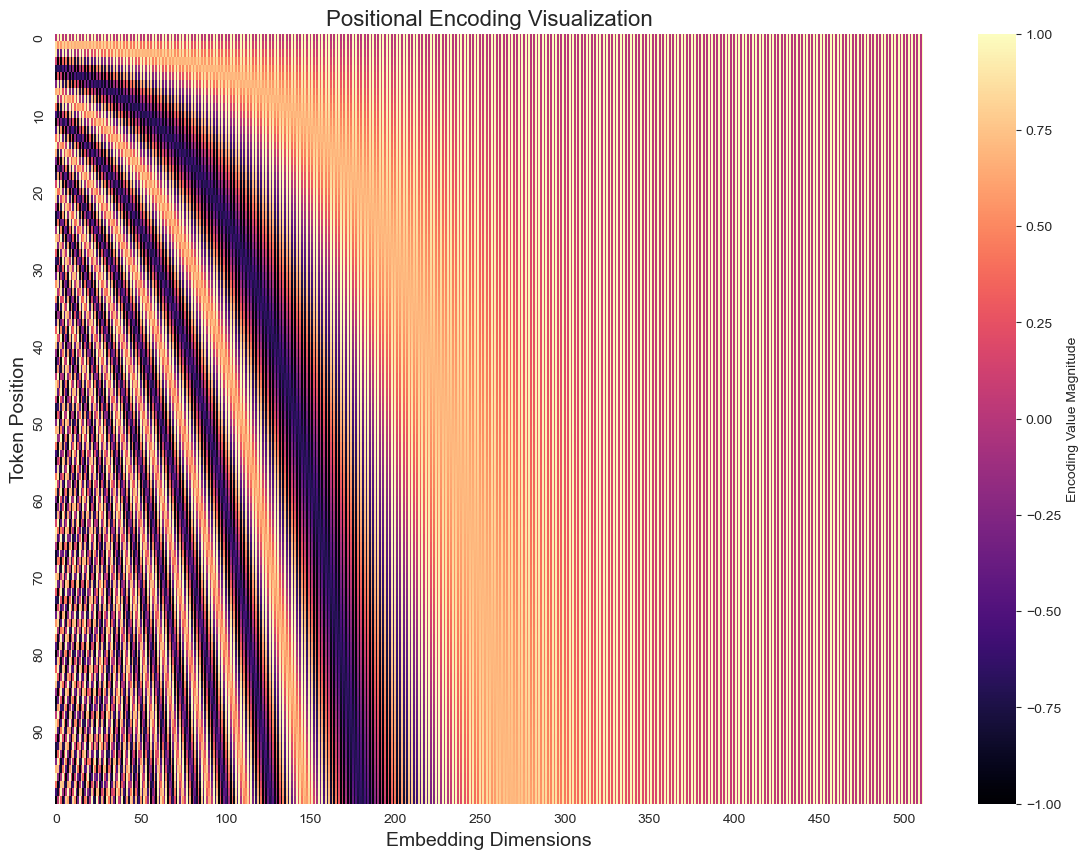

In [5]:
visualize_positional_encoding(pos_enc)

From now there are the interestings things to do:
1. We look at the position of one token, and we look at how the coordinates change as we move in the dimensions (and we have to plot the pair and impair dimensions separately because there is a cos/sin alternance)
2. We fix the dimension coordinate, and we vary the position of the token

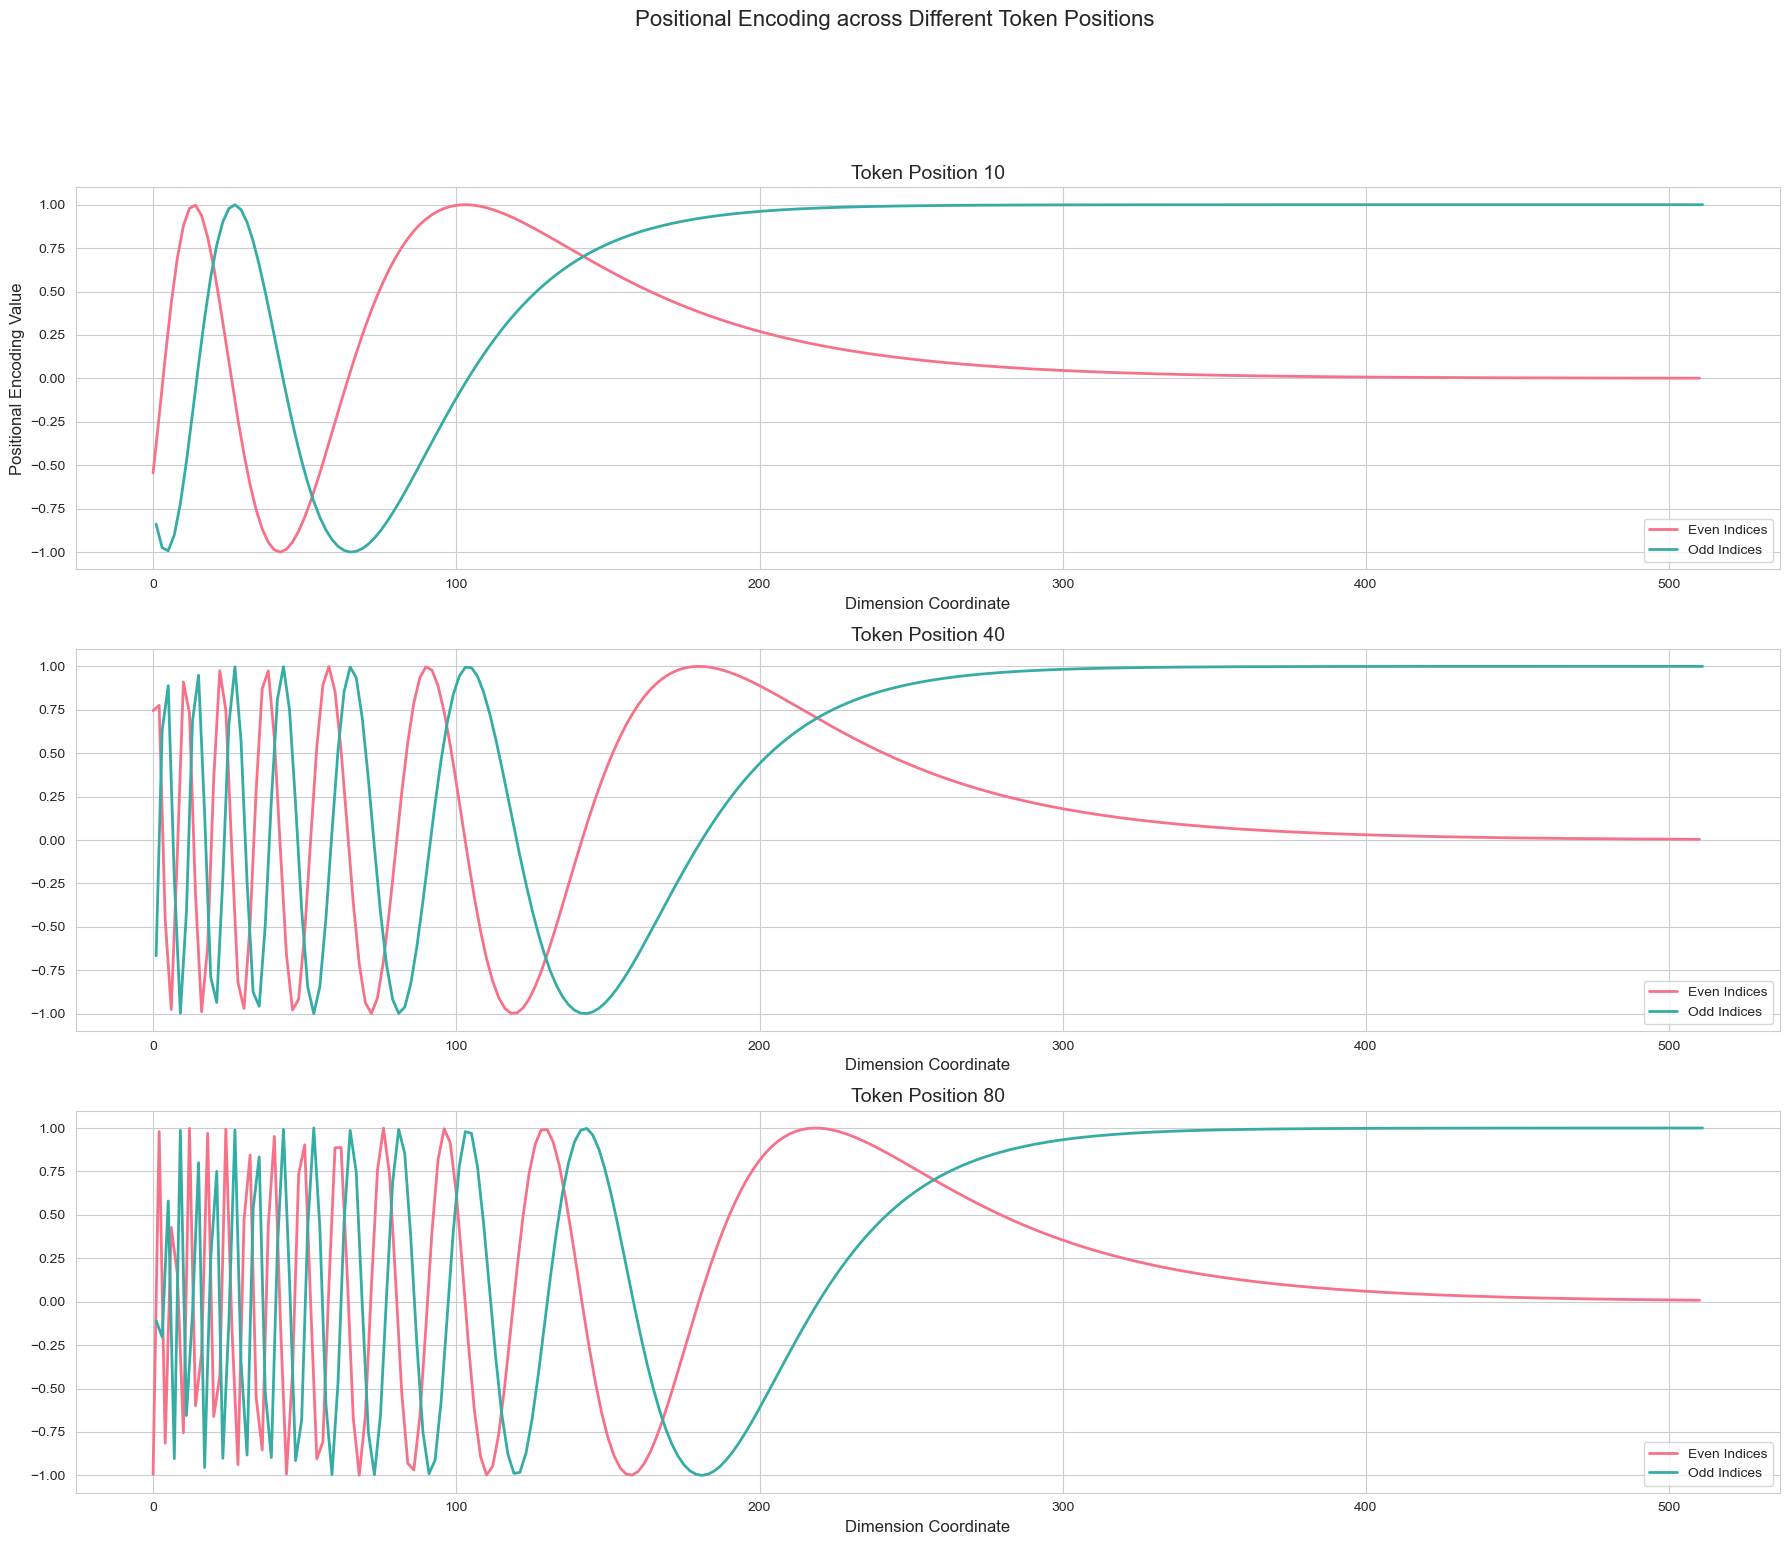

In [6]:
plot_row_pe(token_positions=[10, 40, 80], pos_enc=pos_enc)

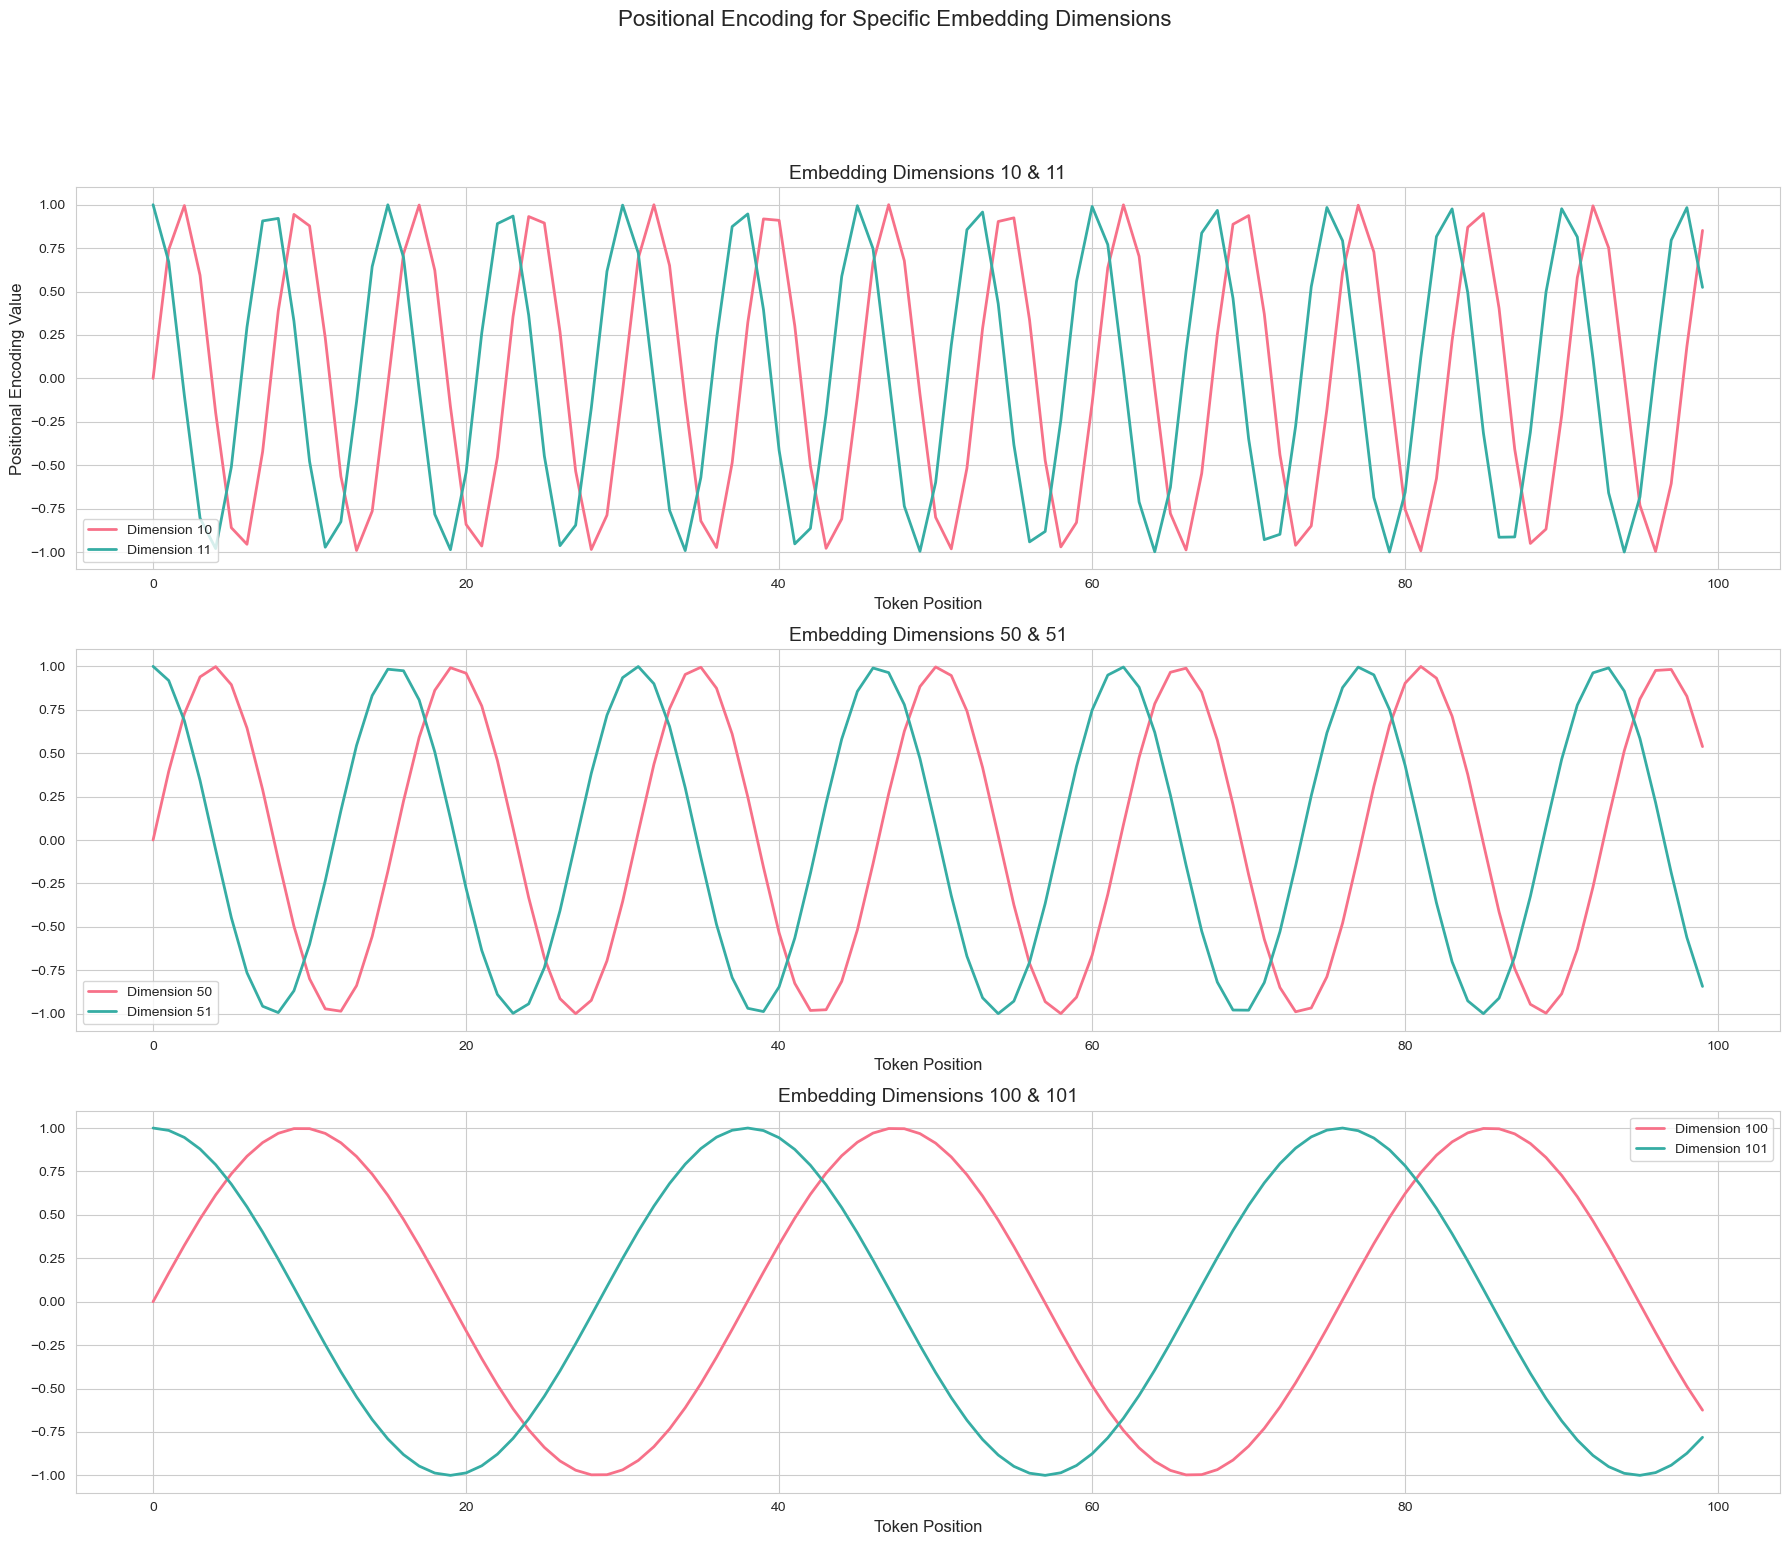

In [7]:
visualize_column_pe(dimensions=[10, 50, 100], pos_enc=pos_enc)

## 1.2 Feedforward Neural Network

In [8]:
class FeedforwardNetwork(nn.Module):
    def __init__(self, d_model, d_ff):
        """
        Initialize the feedforward network.

        :param d_model: Dimension of the model/input.
        :param d_ff: Dimension of the feedforward layer.
        """
        super(FeedforwardNetwork, self).__init__()
        
        # Define the two linear layers and ReLU activation
        self.linear1 = nn.Linear(d_model, d_ff)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        """
        Forward pass through the feedforward network.

        :param x: Input tensor of shape (batch_size, seq_len, d_model).
        :return: Output tensor of shape (batch_size, seq_len, d_model).
        """
        return self.linear2(self.relu(self.linear1(x)))

# Example usage:
# Assuming d_model is 512 (model's dimension) and d_ff is 2048 (dimension of feedforward layer)
model = FeedforwardNetwork(512, 2048)
x = torch.rand(16, 50, 512)  # A dummy input tensor with batch_size=16 and seq_len=50
output = model(x)
print(output.shape)  # This should print torch.Size([16, 50, 512])


torch.Size([16, 50, 512])


## 1.3 Scaled dot-product attention

Details:
- Mathmul: So here we multiply tensors in 4D which can be tricky conceptually. Basically torch.matmul is a batched matrix multiplication, so we only look at the 2 last dimensions. For queries its [seq_len_q, depth] and for keys its [seq_len_k, depth]. 
We can see that we cannot multiply these two tensors, so we need to transpose the second tensor. This is done with the transpose function.

In [9]:
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Compute the scaled dot product attention.

    :param query: Query tensor of shape (batch_size, num_heads, seq_len_q, depth).
    :param key: Key tensor of shape (batch_size, num_heads, seq_len_k, depth).
    :param value: Value tensor of shape (batch_size, num_heads, seq_len_k, depth_v).
    :param mask: Mask tensor to be added to the scaled dot product before softmax.
    :return: Tuple of output tensor and attention weights.
    """
    # Compute the dot product between query and key
    # query has shape [batch_size, num_heads, seq_len_q, depth]
    # key has shape [batch_size, num_heads, seq_len_k, depth]
    
    matmul_qk = torch.matmul(query, key.transpose(-2, -1)) # [batch_size, num_heads, seq_len_q, seq_len_k]

    # Scale by the depth of the key
    d_k = key.size(-1)
    scaled_attention_logits = matmul_qk / math.sqrt(d_k) # [batch_size, num_heads, seq_len_q, seq_len_k]

    # Add the mask (if provided) to the scaled tensor
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # Apply softmax to compute attention weights
    attention_weights = F.softmax(scaled_attention_logits, dim=-1) # [batch_size, num_heads, seq_len_q, seq_len_k]

    # Multiply attention weights with value to get the output
    # value has shape [batch_size, num_heads, seq_len_k, depth]
    output = torch.matmul(attention_weights, value) # [batch_size, num_heads, seq_len_q, depth]

    return output, attention_weights

# Example usage:
# Using some dummy tensors
# The seq_len can be different for query and key because for example for the decoder takes as input the output of the encoder which could have a different sequence len as the one being generated
query = torch.rand(16, 8, 50, 64)  # batch_size=16, num_heads=8, seq_len_q=50, depth=64
key = torch.rand(16, 8, 60, 64)    # seq_len_k=60
value = torch.rand(16, 8, 60, 64)  # seq_len_k=60

output, attention_weights = scaled_dot_product_attention(query, key, value)
print(output.shape)  # This should print torch.Size([16, 8, 50, 64])
print(attention_weights.shape)  # This should print torch.Size([16, 8, 50, 60])


torch.Size([16, 8, 50, 64])
torch.Size([16, 8, 50, 60])


## 1.4 Masking

We need mostly 2 types of masking:
1. Padding Mask
2. Look Ahead Mask

- **Padding Mask** is because we will have sequences of different lengths, for example "I am a student" (l=3) and "It is raining today" (l=4). We need to pad sequences so they all have the same length. But becareful we dont padd with zeros, we padd with ones, because remember in the scaled_dot_product function we add -infty whenever there is a one

- **Look ahead Mask**
This is not useful for the Encoder (we use all the tokens at once to encode the sentence)
However this is useful for the Decoder. When we generate a sentence, we can only look at the current tokens we have already generated and not at the future tokens we have not generated yet. So we need to mask the future tokens.


In [10]:
def create_padding_mask(seq):
    """
    Creates a mask for the padding tokens in the sequence.

    :param seq: Tensor of shape (batch_size, sequence_length)
    :return: Padding mask of shape (batch_size, 1, 1, sequence_length)
    """
    # Create a tensor containing 0s where the sequence is not 0 and 1 otherwise
    mask = (seq == 0).float()

    # Reshape the mask to match the shapes expected by the attention mechanism
    return mask.unsqueeze(1).unsqueeze(2)  # (batch_size, 1, 1, sequence_length)

sequence = torch.tensor([[1, 2, 3, 0, 0], 
                         [4, 5, 6, 7, 0], 
                         [8, 9, 10, 0, 0]])

padding_mask = create_padding_mask(sequence)
print(padding_mask)

tensor([[[[0., 0., 0., 1., 1.]]],


        [[[0., 0., 0., 0., 1.]]],


        [[[0., 0., 0., 1., 1.]]]])


In [12]:
def create_look_ahead_mask(seq_len):
    """
    Creates a look-ahead mask to mask out future tokens in a sequence.

    :param seq_len: seq_len of the mask (sequence_length)
    :return: Look-ahead mask of shape (sequence_length, sequence_length)
    """
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
    return mask  # (sequence_length, sequence_length)

# Example
seq_len = 5
la_mask = create_look_ahead_mask(seq_len)
print(la_mask)


tensor([[0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]])


# 2. Core Transformer Components

## 2.1 Multi-Head Attention

In [13]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model % self.num_heads == 0, "d_model must be divisible by num_heads"
        
        self.depth = d_model // self.num_heads
        
        # For each token we generate the query, key and value vectors by multiplying the input by a matrix
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)
        
        self.fc = nn.Linear(d_model, d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth). Transpose result such that
           the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)
        
    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        
        query = self.wq(query) # [batch_size, seq_len, d_model]
        key = self.wk(key) # [batch_size, seq_len, d_model]
        value = self.wv(value) # [batch_size, seq_len, d_model]
        
        query = self.split_heads(query, batch_size) # [batch_size, num_heads, seq_len, depth]
        key = self.split_heads(key, batch_size) # [batch_size, num_heads, seq_len, depth]
        value = self.split_heads(value, batch_size) # [batch_size, num_heads, seq_len, depth]
        
        # Use the scaled dot-product attention function you've defined earlier
        attention_output, _ = scaled_dot_product_attention(query, key, value, mask) # [batch_size, num_heads, seq_len, depth]
        # _ corresponds to attention_weights
        
        # Here we concat the heads together
        attention_output = attention_output.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)
        # with permute we have [batch_size, seq_len, num_heads, depth]
        # with view we have [batch_size, seq_len, d_model]
        
        return self.fc(attention_output)

# Example usage:
mha = MultiHeadAttention(d_model=512, num_heads=8)
y = torch.rand(1, 60, 512)  # batch_size=1, seq_len=60, d_model=512
out = mha(y, y, y)
print(out.shape)  # This should print torch.Size([1, 60, 512])


torch.Size([1, 60, 512])


In [17]:
y.shape

torch.Size([1, 60, 512])

In [16]:
out.shape

torch.Size([1, 60, 512])

## 2.2 Transformer Block

In [18]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(TransformerBlock, self).__init__()
        
        # 1. Multi-Head Attention mechanism
        self.attention = MultiHeadAttention(d_model, num_heads)
        
        # 2. Feed-Forward Neural Network
        self.feed_forward = FeedforwardNetwork(d_model, d_ff)
        
        # Layer normalization
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        
        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        # Multi-Head Attention with residual connection
        attention_output = self.attention(query, key, value, mask)
        x = self.norm1(attention_output + query)
        x = self.dropout(x)
        
        # Feed-Forward Neural Network with residual connection
        ff_output = self.feed_forward(x)
        out = self.norm2(ff_output + x)
        out = self.dropout(out)
        
        return out

# Example usage:
transformer_block = TransformerBlock(d_model=512, num_heads=8, d_ff=2048)
y = torch.rand(1, 60, 512)  # batch_size=1, seq_len=60, d_model=512
out = transformer_block(y, y, y)
print(out.shape)  # This should print torch.Size([1, 60, 512])


torch.Size([1, 60, 512])


# 3. Final Model

## 3.1 Encoder Block

In [19]:
class EncoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderBlock, self).__init__()
        
        # Multi-Head Attention layer
        self.mha = MultiHeadAttention(d_model, num_heads)
        
        # Feed-Forward layer
        self.ffn = FeedforwardNetwork(d_model, d_ff)
        
        # Layer Normalization layers
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        # Multi-Head Attention layer with residual connection
        attn_output = self.mha(x, x, x, mask)
        x = self.layernorm1(x + self.dropout1(attn_output))
        
        # Feed-Forward layer with residual connection
        ffn_output = self.ffn(x)
        x = self.layernorm2(x + self.dropout2(ffn_output))
        
        return x

# 3.2 Full Encoder

In [20]:
class Encoder(nn.Module):
    def __init__(self, num_blocks, d_model, num_heads, d_ff, dropout=0.1):
        super(Encoder, self).__init__()
        
        # A stack of num_blocks EncoderBlocks
        self.encoder_blocks = nn.ModuleList(
            [EncoderBlock(d_model, num_heads, d_ff, dropout) for _ in range(num_blocks)]
        )
        
        # Positional Encoding can be added here if needed
        
    def forward(self, x, mask):
        for block in self.encoder_blocks:
            x = block(x, mask)
        return x

# Example usage:
encoder = Encoder(num_blocks=6, d_model=512, num_heads=8, d_ff=2048, dropout=0.1)
x = torch.rand(16, 50, 512)  # [batch_size, seq_len, d_model]
mask = None  # Here, you can provide a mask if necessary
output = encoder(x, mask)
print(output.shape)  # This should print torch.Size([16, 50, 512])

torch.Size([16, 50, 512])


## 3.3 Decoder Block

In [24]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderBlock, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.dropout1 = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.dropout2 = nn.Dropout(dropout)
        self.norm2 = nn.LayerNorm(d_model)
        
        self.ffn = FeedforwardNetwork(d_model, d_ff)
        self.dropout3 = nn.Dropout(dropout)
        self.norm3 = nn.LayerNorm(d_model)
        
    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        # Masked Multi-Head Attention
        attn1, attn_weights1 = self.mha1(x, x, x, look_ahead_mask)
        out1 = self.norm1(x + self.dropout1(attn1))
        
        # Multi-Head Attention with Encoder's Output
        attn2, attn_weights2 = self.mha2(out1, enc_output, enc_output, padding_mask)
        out2 = self.norm2(out1 + self.dropout2(attn2))
        
        # Feed-Forward Network
        ffn_output = self.ffn(out2)
        out3 = self.norm3(out2 + self.dropout3(ffn_output))
        
        return out3, attn_weights1, attn_weights2

## 3.4 Decoder

In [78]:
class Decoder(nn.Module):
    def __init__(self, target_vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len, dropout=0.1):
        super(Decoder, self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(max_seq_len, d_model)
        
        self.dec_blocks = nn.ModuleList([
            DecoderBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        self.fc = nn.Linear(d_model, target_vocab_size)
        
    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        print("x shape", x.shape)
        seq_len = x.size(1)
        batch_size = x.size(0)
        print("seq_len", seq_len)
        print("x before embedding", x)
        
        attention_weights = {}
        print("Now computing embedding of x..")
        
        x = self.embedding(x) * math.sqrt(self.d_model) # shape [batch_size, seq_len, d_model]
        print(f'After embedding: {x.shape}')
        print("positional encoding shape", self.pos_encoding.shape) # shape [seq_len, d_model]
        print("Positional encoding shape until seq_len", self.pos_encoding[:seq_len, :].shape)

        # Adjust for the batch size
        x += self.pos_encoding[:seq_len, :].unsqueeze(0).repeat(batch_size, 1, 1)
        print(f'After positional encoding: {x.shape}')
        
        for i in range(self.num_layers):
            x, attn_weights1, attn_weights2 = self.dec_blocks[i](x, enc_output, look_ahead_mask, padding_mask)
            attention_weights[f'decoder_layer{i+1}_block1'] = attn_weights1
            attention_weights[f'decoder_layer{i+1}_block2'] = attn_weights2
            print(f'After decoder layer {i+1}: {x.shape}')
        
        output = self.fc(x)
        print(f'After fully connected layer: {output.shape}')
        
        return output, attention_weights


In [79]:
# Dummy input
batch_size = 2
src_seq_len = 10
target_seq_len = 8

# We'll use random integers as dummy input data representing token IDs.
source_seq = torch.randint(0, 1000, (batch_size, src_seq_len))
target_seq = torch.randint(0, 1000, (batch_size, target_seq_len))

# Define the Encoder
encoder = Encoder(num_blocks=2, d_model=512, num_heads=8, d_ff=2048, dropout=0.1)
embedded_input = torch.rand(batch_size, src_seq_len, 512)  # For this example, we are using a random tensor as an embedded input.
enc_output = encoder(embedded_input, mask)

In [80]:
target_seq.shape

torch.Size([2, 8])

In [81]:
embedded_input.shape

torch.Size([2, 10, 512])

In [82]:
enc_output.shape

torch.Size([2, 10, 512])

In [83]:
# Create masks
# For the Decoder's first attention block
look_ahead_mask = create_look_ahead_mask(target_seq_len)
dec_target_padding_mask = create_padding_mask(target_seq)
combined_mask = torch.maximum(dec_target_padding_mask, look_ahead_mask)

# For the Decoder's second attention block
padding_mask = create_padding_mask(source_seq)

In [84]:
combined_mask

tensor([[[[0., 1., 1., 1., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1., 1., 1., 1.],
          [0., 0., 0., 1., 1., 1., 1., 1.],
          [0., 0., 0., 0., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0., 1., 1., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]],


        [[[0., 1., 1., 1., 1., 1., 1., 1.],
          [0., 0., 1., 1., 1., 1., 1., 1.],
          [0., 0., 0., 1., 1., 1., 1., 1.],
          [0., 0., 0., 0., 1., 1., 1., 1.],
          [0., 0., 0., 0., 0., 1., 1., 1.],
          [0., 0., 0., 0., 0., 0., 1., 1.],
          [0., 0., 0., 0., 0., 0., 0., 1.],
          [0., 0., 0., 0., 0., 0., 0., 0.]]]])

In [85]:

# Define the Decoder
decoder = Decoder(
    target_vocab_size=1000,
    d_model=512,
    num_heads=8,
    d_ff=2048,
    num_layers=2,
    max_seq_len=target_seq_len
)


In [86]:

# Get decoder output
final_output, attn_weights = decoder(target_seq, enc_output, combined_mask, padding_mask)


print(final_output.shape)  # Should print [batch_size, target_seq_len, target_vocab_size]

# Just for clarity:
# final_output holds the Decoder's output which are logits over the target vocabulary.
# attn_weights holds attention weights of each layer, useful for visualization and understanding.

x shape torch.Size([2, 8])
seq_len 8
x before embedding tensor([[ 72, 298, 175, 877, 442, 907, 402, 220],
        [884, 901, 461, 264, 735, 350, 872, 830]])
Now computing embedding of x..
After embedding: torch.Size([2, 8, 512])
positional encoding shape torch.Size([8, 512])
Positional encoding shape until seq_len torch.Size([8, 512])
After positional encoding: torch.Size([2, 8, 512])
After decoder layer 1: torch.Size([2, 8, 512])
After decoder layer 2: torch.Size([2, 8, 512])
After fully connected layer: torch.Size([2, 8, 1000])
torch.Size([2, 8, 1000])


## 3.5 Full Transformer

# 4. Trainining Loop